# Recommendation Systems: Amazon product reviews

### Context: 

Online E-commerce websites like Amazon, Flipkart uses different recommendation models to provide different suggestions to different users. Amazon currently uses item-to-item collaborative filtering, which scales to massive data sets and produces high-quality recommendations in real-time.

### Objective:
Build a recommendation system to recommend products to customers based on the their previous ratings for other products.

### Dataset Attributes
- userId : Every user identified with a unique id
- productId : Every product identified with a unique id
- Rating : Rating of the corresponding product by the corresponding user
- timestamp : Time of the rating ( ignore this column for this exercise)

In [1]:
import numpy as np
import pandas as pd
import math
import json
import time
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from sklearn.neighbors import NearestNeighbors
# from sklearn.externals import joblib
import scipy.sparse
from scipy.sparse import csr_matrix
import warnings; warnings.simplefilter('ignore')
%matplotlib inline

In [2]:
#Import the data set
df = pd.read_csv('ratings_Electronics.csv', header=None)
df.columns = ['user_id', 'prod_id', 'rating', 'prod_name']
df = df.drop('prod_name', axis=1)
df_copy = df.copy(deep=True)

In [3]:
# see few rows of the imported dataset
df.head()

user_id     prod_id  rating
0   AKM1MP6P0OYPR  0132793040     5.0
1  A2CX7LUOHB2NDG  0321732944     5.0
2  A2NWSAGRHCP8N5  0439886341     1.0
3  A2WNBOD3WNDNKT  0439886341     3.0
4  A1GI0U4ZRJA8WN  0439886341     1.0

In [4]:
# Check the number of rows and columns
rows, columns = df.shape[0], df.shape[1]
print("No of rows: ", rows) 
print("No of columns: ", columns) 

No of rows:  7824482
No of columns:  3


In [5]:
#Check Data types
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7824482 entries, 0 to 7824481
Data columns (total 3 columns):
 #   Column   Dtype  
---  ------   -----  
 0   user_id  object 
 1   prod_id  object 
 2   rating   float64
dtypes: float64(1), object(2)
memory usage: 179.1+ MB


In [6]:
# Check for missing values present
print('Number of missing values across columns-\n',df.isnull().sum())

Number of missing values across columns-
 user_id    0
prod_id    0
rating     0
dtype: int64


In [7]:
# Summary statistics of 'rating' variable
df['rating'].describe()

count    7.824482e+06
mean     4.012337e+00
std      1.380910e+00
min      1.000000e+00
25%      3.000000e+00
50%      5.000000e+00
75%      5.000000e+00
max      5.000000e+00
Name: rating, dtype: float64

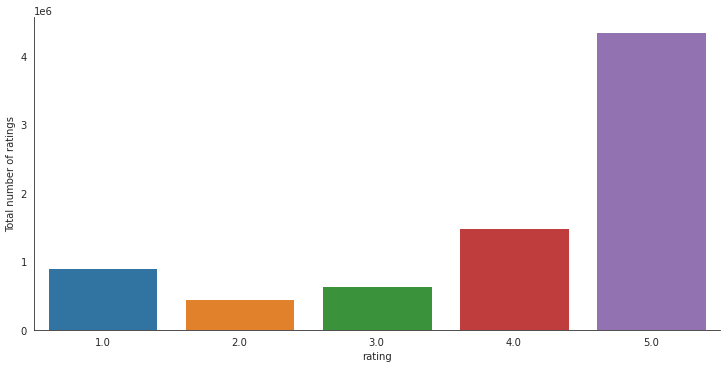

In [8]:
# Check the distribution of the ratings 
with sns.axes_style('white'):
    g = sns.factorplot("rating", data=df, aspect=2.0,kind='count')
    g.set_ylabels("Total number of ratings") 

In [9]:
# Number of unique user id and product id in the data
print('Number of unique USERS in Raw data = ', df['user_id'].nunique())
print('Number of unique ITEMS in Raw data = ', df['prod_id'].nunique())

Number of unique USERS in Raw data =  4201696
Number of unique ITEMS in Raw data =  476002


In [10]:
# Top 10 users based on rating
most_rated = df.groupby('user_id').size().sort_values(ascending=False)[:10]
most_rated 

user_id
A5JLAU2ARJ0BO     520
ADLVFFE4VBT8      501
A3OXHLG6DIBRW8    498
A6FIAB28IS79      431
A680RUE1FDO8B     406
A1ODOGXEYECQQ8    380
A36K2N527TXXJN    314
A2AY4YUOX2N1BQ    311
AWPODHOB4GFWL     308
A25C2M3QF9G7OQ    296
dtype: int64

In [11]:
# take a sub dataset of those users who have given 50 or more number of ratings, to make the dataset less sparse
counts = df['user_id'].value_counts()
df_final = df[df['user_id'].isin(counts[counts >= 50].index)]

In [12]:
print('The number of observations in the final data =', len(df_final))
print('Number of unique USERS in the final data = ', df_final['user_id'].nunique())
print('Number of unique ITEMS in the final data = ', df_final['prod_id'].nunique())

The number of observations in the final data = 125871
Number of unique USERS in the final data =  1540
Number of unique ITEMS in the final data =  48190


In [13]:
# calculate density of the rating matrix
final_ratings_matrix = df_final.pivot(index = 'user_id', columns ='prod_id', values = 'rating').fillna(0)
print('Shape of final_ratings_matrix: ', final_ratings_matrix.shape)

given_num_of_ratings = np.count_nonzero(final_ratings_matrix)
print('given_num_of_ratings = ', given_num_of_ratings)
possible_num_of_ratings = final_ratings_matrix.shape[0] * final_ratings_matrix.shape[1]
print('possible_num_of_ratings = ', possible_num_of_ratings)
density = (given_num_of_ratings/possible_num_of_ratings)
density *= 100
print ('density: {:4.2f}%'.format(density))
final_ratings_matrix.head()

Shape of final_ratings_matrix:  (1540, 48190)
given_num_of_ratings =  125871
possible_num_of_ratings =  74212600
density: 0.17%


prod_id         0594451647  0594481813  0970407998  0972683275  1400501466  \
user_id                                                                      
A100UD67AHFODS         0.0         0.0         0.0         0.0         0.0   
A100WO06OQR8BQ         0.0         0.0         0.0         0.0         0.0   
A105S56ODHGJEK         0.0         0.0         0.0         0.0         0.0   
A105TOJ6LTVMBG         0.0         0.0         0.0         0.0         0.0   
A10AFVU66A79Y1         0.0         0.0         0.0         0.0         0.0   

prod_id         1400501520  1400501776  1400532620  1400532655  140053271X  \
user_id                                                                      
A100UD67AHFODS         0.0         0.0         0.0         0.0         0.0   
A100WO06OQR8BQ         0.0         0.0         0.0         0.0         0.0   
A105S56ODHGJEK         0.0         0.0         0.0         0.0         0.0   
A105TOJ6LTVMBG         0.0         0.0         0.0         0.0         0.0   
A10AFVU66A79Y1         0.0         0.0         0.0         0.0         0.0   

prod_id         ...  B00L5YZCCG  B00L8I6SFY  B00L8QCVL6  B00LA6T0LS  \
user_id         ...                                                   
A100UD67AHFODS  ...         0.0         0.0         0.0         0.0   
A100WO06OQR8BQ  ...         0.0         0.0         0.0         0.0   
A105S56ODHGJEK  ...         0.0         0.0         0.0         0.0   
A105TOJ6LTVMBG  ...         0.0         0.0         0.0         0.0   
A10AFVU66A79Y1  ...         0.0         0.0         0.0         0.0   

prod_id         B00LBZ1Z7K  B00LED02VY  B00LGN7Y3G  B00LGQ6HL8  B00LI4ZZO8  \
user_id                                                                      
A100UD67AHFODS         0.0         0.0         0.0         0.0         0.0   
A100WO06OQR8BQ         0.0         0.0         0.0         0.0         0.0   
A105S56ODHGJEK         0.0         0.0         0.0         0.0         0.0   
A105TOJ6LTVMBG         0.0         0.0         0.0         0.0         0.0   
A10AFVU66A79Y1         0.0         0.0         0.0         0.0         0.0   

prod_id         B00LKG1MC8  
user_id                     
A100UD67AHFODS         0.0  
A100WO06OQR8BQ         0.0  
A105S56ODHGJEK         0.0  
A105TOJ6LTVMBG         0.0  
A10AFVU66A79Y1         0.0  

[5 rows x 48190 columns]

In [14]:
# build popularity based recommendation systems
# make a dataframe having the average rating and ratings count of each product
average_rating = df_final.groupby('prod_id').mean()['rating']
count_rating = df_final.groupby('prod_id').count()['rating']
final_rating = pd.DataFrame({'avg_rating':average_rating, 'rating_count':count_rating})

In [15]:
final_rating.shape

(48190, 2)

In [16]:
#defining a function to get the top n products based on highest average rating and some minimum interactions (minimum number of ratings) of that product
def top_n_products(data, n, min_interaction):
    recommendations = data[data['rating_count'] > min_interaction]
    recommendations = recommendations.sort_values(by='avg_rating', ascending=False)
    
    return recommendations.index[:n]      

In [17]:
# Recommending top 5 products based on popularity and with minimum interactions of 50
list(top_n_products(final_rating, 5, 50))

['B001TH7GUU', 'B003ES5ZUU', 'B0019EHU8G', 'B006W8U2MU', 'B000QUUFRW']

In [18]:
# Recommending top 5 products based on popularity and with minimum interactions of 100
list(top_n_products(final_rating, 5, 100))

['B003ES5ZUU', 'B000N99BBC', 'B007WTAJTO', 'B002V88HFE', 'B004CLYEDC']

In [19]:
# Build Collaborative Filtering based Recommendation System
from sklearn.metrics.pairwise import cosine_similarity

In [20]:
# first compute the user-item interactions matrix by making the userid as index
interactions_matrix = df_final.pivot(index='user_id', columns='prod_id', values='rating')
interactions_matrix

prod_id         0594451647  0594481813  0970407998  0972683275  1400501466  \
user_id                                                                      
A100UD67AHFODS         NaN         NaN         NaN         NaN         NaN   
A100WO06OQR8BQ         NaN         NaN         NaN         NaN         NaN   
A105S56ODHGJEK         NaN         NaN         NaN         NaN         NaN   
A105TOJ6LTVMBG         NaN         NaN         NaN         NaN         NaN   
A10AFVU66A79Y1         NaN         NaN         NaN         NaN         NaN   
...                    ...         ...         ...         ...         ...   
AZBXKUH4AIW3X          NaN         NaN         NaN         NaN         NaN   
AZCE11PSTCH1L          NaN         NaN         NaN         NaN         NaN   
AZMY6E8B52L2T          NaN         NaN         NaN         NaN         NaN   
AZNUHQSHZHSUE          NaN         NaN         NaN         NaN         NaN   
AZOK5STV85FBJ          NaN         NaN         NaN         NaN         NaN   

prod_id         1400501520  1400501776  1400532620  1400532655  140053271X  \
user_id                                                                      
A100UD67AHFODS         NaN         NaN         NaN         NaN         NaN   
A100WO06OQR8BQ         NaN         NaN         NaN         NaN         NaN   
A105S56ODHGJEK         NaN         NaN         NaN         NaN         NaN   
A105TOJ6LTVMBG         NaN         NaN         NaN         NaN         NaN   
A10AFVU66A79Y1         NaN         NaN         NaN         NaN         NaN   
...                    ...         ...         ...         ...         ...   
AZBXKUH4AIW3X          NaN         NaN         NaN         NaN         NaN   
AZCE11PSTCH1L          NaN         NaN         NaN         NaN         NaN   
AZMY6E8B52L2T          NaN         NaN         NaN         NaN         NaN   
AZNUHQSHZHSUE          NaN         NaN         NaN         NaN         NaN   
AZOK5STV85FBJ          NaN         NaN         NaN         NaN         NaN   

prod_id         ...  B00L5YZCCG  B00L8I6SFY  B00L8QCVL6  B00LA6T0LS  \
user_id         ...                                                   
A100UD67AHFODS  ...         NaN         NaN         NaN         NaN   
A100WO06OQR8BQ  ...         NaN         NaN         NaN         NaN   
A105S56ODHGJEK  ...         NaN         NaN         NaN         NaN   
A105TOJ6LTVMBG  ...         NaN         NaN         NaN         NaN   
A10AFVU66A79Y1  ...         NaN         NaN         NaN         NaN   
...             ...         ...         ...         ...         ...   
AZBXKUH4AIW3X   ...         NaN         NaN         NaN         NaN   
AZCE11PSTCH1L   ...         NaN         NaN         NaN         NaN   
AZMY6E8B52L2T   ...         NaN         NaN         NaN         NaN   
AZNUHQSHZHSUE   ...         NaN         NaN         NaN         NaN   
AZOK5STV85FBJ   ...         NaN         NaN         NaN         NaN   

prod_id         B00LBZ1Z7K  B00LED02VY  B00LGN7Y3G  B00LGQ6HL8  B00LI4ZZO8  \
user_id                                                                      
A100UD67AHFODS         NaN         NaN         NaN         NaN         NaN   
A100WO06OQR8BQ         NaN         NaN         NaN         NaN         NaN   
A105S56ODHGJEK         NaN         NaN         NaN         NaN         NaN   
A105TOJ6LTVMBG         NaN         NaN         NaN         NaN         NaN   
A10AFVU66A79Y1         NaN         NaN         NaN         NaN         NaN   
...                    ...         ...         ...         ...         ...   
AZBXKUH4AIW3X          NaN         NaN         NaN         NaN         NaN   
AZCE11PSTCH1L          NaN         NaN         NaN         NaN         NaN   
AZMY6E8B52L2T          NaN         NaN         NaN         NaN         NaN   
AZNUHQSHZHSUE          NaN         NaN         NaN         NaN         NaN   
AZOK5STV85FBJ          NaN         NaN         NaN         NaN         NaN   

prod_id         B00LKG1MC8  
us

In [21]:
interactions_matrix.fillna(0, inplace=True)
interactions_matrix.head()

prod_id         0594451647  0594481813  0970407998  0972683275  1400501466  \
user_id                                                                      
A100UD67AHFODS         0.0         0.0         0.0         0.0         0.0   
A100WO06OQR8BQ         0.0         0.0         0.0         0.0         0.0   
A105S56ODHGJEK         0.0         0.0         0.0         0.0         0.0   
A105TOJ6LTVMBG         0.0         0.0         0.0         0.0         0.0   
A10AFVU66A79Y1         0.0         0.0         0.0         0.0         0.0   

prod_id         1400501520  1400501776  1400532620  1400532655  140053271X  \
user_id                                                                      
A100UD67AHFODS         0.0         0.0         0.0         0.0         0.0   
A100WO06OQR8BQ         0.0         0.0         0.0         0.0         0.0   
A105S56ODHGJEK         0.0         0.0         0.0         0.0         0.0   
A105TOJ6LTVMBG         0.0         0.0         0.0         0.0         0.0   
A10AFVU66A79Y1         0.0         0.0         0.0         0.0         0.0   

prod_id         ...  B00L5YZCCG  B00L8I6SFY  B00L8QCVL6  B00LA6T0LS  \
user_id         ...                                                   
A100UD67AHFODS  ...         0.0         0.0         0.0         0.0   
A100WO06OQR8BQ  ...         0.0         0.0         0.0         0.0   
A105S56ODHGJEK  ...         0.0         0.0         0.0         0.0   
A105TOJ6LTVMBG  ...         0.0         0.0         0.0         0.0   
A10AFVU66A79Y1  ...         0.0         0.0         0.0         0.0   

prod_id         B00LBZ1Z7K  B00LED02VY  B00LGN7Y3G  B00LGQ6HL8  B00LI4ZZO8  \
user_id                                                                      
A100UD67AHFODS         0.0         0.0         0.0         0.0         0.0   
A100WO06OQR8BQ         0.0         0.0         0.0         0.0         0.0   
A105S56ODHGJEK         0.0         0.0         0.0         0.0         0.0   
A105TOJ6LTVMBG         0.0         0.0         0.0         0.0         0.0   
A10AFVU66A79Y1         0.0         0.0         0.0         0.0         0.0   

prod_id         B00LKG1MC8  
user_id                     
A100UD67AHFODS         0.0  
A100WO06OQR8BQ         0.0  
A105S56ODHGJEK         0.0  
A105TOJ6LTVMBG         0.0  
A10AFVU66A79Y1         0.0  

[5 rows x 48190 columns]

In [22]:
# make user index intege type
interactions_matrix['user_index'] = np.arange(0, interactions_matrix.shape[0], 1)
interactions_matrix.set_index(['user_index'], inplace=True)

# Actual ratings given by users
interactions_matrix.head()

prod_id     0594451647  0594481813  0970407998  0972683275  1400501466  \
user_index                                                               
0                  0.0         0.0         0.0         0.0         0.0   
1                  0.0         0.0         0.0         0.0         0.0   
2                  0.0         0.0         0.0         0.0         0.0   
3                  0.0         0.0         0.0         0.0         0.0   
4                  0.0         0.0         0.0         0.0         0.0   

prod_id     1400501520  1400501776  1400532620  1400532655  140053271X  ...  \
user_index                                                              ...   
0                  0.0         0.0         0.0         0.0         0.0  ...   
1                  0.0         0.0         0.0         0.0         0.0  ...   
2                  0.0         0.0         0.0         0.0         0.0  ...   
3                  0.0         0.0         0.0         0.0         0.0  ...   
4                  0.0         0.0         0.0         0.0         0.0  ...   

prod_id     B00L5YZCCG  B00L8I6SFY  B00L8QCVL6  B00LA6T0LS  B00LBZ1Z7K  \
user_index                                                               
0                  0.0         0.0         0.0         0.0         0.0   
1                  0.0         0.0         0.0         0.0         0.0   
2                  0.0         0.0         0.0         0.0         0.0   
3                  0.0         0.0         0.0         0.0         0.0   
4                  0.0         0.0         0.0         0.0         0.0   

prod_id     B00LED02VY  B00LGN7Y3G  B00LGQ6HL8  B00LI4ZZO8  B00LKG1MC8  
user_index                                                              
0                  0.0         0.0         0.0         0.0         0.0  
1                  0.0         0.0         0.0         0.0         0.0  
2                  0.0         0.0         0.0         0.0         0.0  
3                  0.0         0.0         0.0         0.0         0.0  
4                  0.0         0.0         0.0         0.0         0.0  

[5 rows x 48190 columns]

In [23]:
interactions_matrix.shape

(1540, 48190)

In [24]:
# defining a function to get similar users and return the most similar users and thir similarity scores
def similar_users(user_index, interactions_matrix):
    similarity = []
    for user in range(0, interactions_matrix.shape[0]):
        sim = cosine_similarity([interactions_matrix.loc[user_index]], [interactions_matrix.loc[user]])
        similarity.append((user, sim))
        
    similarity.sort(key=lambda x: x[1], reverse=True)
    most_similar_users = [tup[0] for tup in similarity]
    similarity_score = [tup[1] for tup in similarity]
    most_similar_users.remove(user_index)
    similarity_score.remove(similarity_score[0])
    return most_similar_users, similarity_score

In [25]:
# Finding out top 10 similar users to the user index 3
similar = similar_users(3, interactions_matrix)[0][0:10]
similar

[320, 12, 793, 261, 156, 1493, 1250, 567, 753, 1360]

In [26]:
# printing the original user ids associated with the above user index
for i in similar:
    print(final_ratings_matrix.index[i])

A1TQBAHI3M4ZBQ
A10ZFE6YE0UHW8
A2XXBZPQT5EXHV
A1NZLRAZJGD99W
A1D27BCSYV7VWH
AVTJEWTCJ3PBE
AAK6SOEJY30YG
A2GKMXRLI7KLFP
A2VCXIAWCPQ13P
AKSFZ4G1AXYFC


In [27]:
#Print the similarity score
similar_users(3, interactions_matrix)[1][0:10]

[array([[0.05662371]]),
 array([[0.05549645]]),
 array([[0.05098326]]),
 array([[0.05024185]]),
 array([[0.05003874]]),
 array([[0.04930111]]),
 array([[0.04889354]]),
 array([[0.04672744]]),
 array([[0.04637283]]),
 array([[0.04492668]])]

In [28]:
# Finding out top 10 similar users to the user index 1521
similar = similar_users(1521,interactions_matrix)[0][0:10]
similar

[991, 1065, 1012, 1402, 1371, 1278, 1518, 692, 785, 161]

In [29]:
# printing the original user ids associated with the above user index
for i in similar:
    print(final_ratings_matrix.index[i])

A3FBM0RMCMAABV
A3MUSWDCTZINQZ
A3HQAPXAJV7PRX
AO09RWV40IX78
ALQ4USPEQ9L5N
ACSX5AIZE3MJ9
AY3D7DG5L5WCK
A2QDOJFFLFGF18
A2XIOXRRYX0KZY
A1DSRM2P0WGQNS


In [30]:
#Print the similarity score
similar_users(1521,interactions_matrix)[1][0:10]

[array([[0.10889304]]),
 array([[0.10538068]]),
 array([[0.1026758]]),
 array([[0.09418291]]),
 array([[0.09149062]]),
 array([[0.09135361]]),
 array([[0.09028898]]),
 array([[0.08735684]]),
 array([[0.08673386]]),
 array([[0.08478815]])]

In [31]:
# To build a more robust similar user identification, we can also put a threshold to the similarity score
# defining the recommendations function to get recommendations by using the similar users preferences and return the recommendations of products
def recommendations(user_index, num_of_products, interactions_matrix):
    most_similar_users = similar_users(user_index, interactions_matrix)[0]
    product_ids = set(list(interactions_matrix.columns[np.where(interactions_matrix.loc[user_index] > 0)]))
    recommendations = []
    
    observed_interactions = product_ids.copy()
    for similar_user in most_similar_users:
        if len(recommendations) < num_of_products:
            similar_user_product_ids = set(list(interactions_matrix.columns[np.where(interactions_matrix.loc[similar_user] > 0)]))
            recommendations.extend(list(similar_user_product_ids.difference(observed_interactions)))
            observed_interactions = observed_interactions.union(similar_user_product_ids)
        else:
            break
    
    return recommendations[:num_of_products]

In [32]:
# Recommend 5 products to user index 3 based on similarity based collaborative filtering
recommendations(3, 5, interactions_matrix)

['B0015ZIS8K', 'B001DDW9V6', 'B000MFG44Y', 'B002DS4HTM', 'B000Z80ICM']

In [33]:
# Recommend 5 products to user index 1521 based on similarity based collaborative filtering
recommendations(1521, 5, interactions_matrix)

['B007BY0MIS', 'B00EHZYWGM', 'B007X3VEUW', 'B0080EBMM8', 'B002L6GEKG']

In [34]:
# Build Model-based Collaborative Filtering: Singular Value Decomposition
from scipy.sparse.linalg import svds # for sparse matrices

# Singular Value Decomposition
U, sigma, Vt = svds(interactions_matrix, k = 50) # here the number of latent features are 50. 
# Construct diagonal array in SVD
sigma = np.diag(sigma)

In [35]:
#checking the shape of the U matrix
U.shape

(1540, 50)

In [36]:
#checking the shape of the sigma matrix
sigma.shape

(50, 50)

In [37]:
#checking the shape of the Vt matrix
Vt.shape

(50, 48190)

In [38]:
all_user_predicted_ratings = np.dot(np.dot(U, sigma), Vt) 
# all_user_predicted_ratings.shape

# Create a dataframe of predicted ratings (all_user_predicted_ratings) by using the columns from interactions_matrix
preds_df = pd.DataFrame(all_user_predicted_ratings, index=interactions_matrix.index, columns=interactions_matrix.columns)
preds_df.head()

prod_id     0594451647  0594481813  0970407998  0972683275  1400501466  \
user_index                                                               
0             0.005086    0.002178    0.003668   -0.040843    0.009640   
1             0.002286   -0.010898   -0.000724    0.130259    0.007506   
2            -0.001655   -0.002675   -0.007355    0.007264    0.005152   
3             0.001856    0.011019   -0.005910   -0.014134    0.000179   
4             0.001115   -0.002670    0.011018    0.014434    0.010319   

prod_id     1400501520  1400501776  1400532620  1400532655  140053271X  ...  \
user_index                                                              ...   
0             0.006808    0.020659    0.000649    0.020331    0.005633  ...   
1            -0.003350    0.063711   -0.000674    0.016111   -0.002433  ...   
2            -0.003986   -0.003480    0.006961   -0.006606   -0.002719  ...   
3             0.001877   -0.005391   -0.001709    0.004968    0.001402  ...   
4             0.006002    0.017151    0.003726    0.001404    0.005645  ...   

prod_id     B00L5YZCCG  B00L8I6SFY  B00L8QCVL6  B00LA6T0LS  B00LBZ1Z7K  \
user_index                                                               
0             0.000238   -0.061477    0.001214   -0.123433    0.028490   
1            -0.000038    0.013766    0.001473    0.025588   -0.042103   
2            -0.001708   -0.051040    0.000325   -0.054867    0.017870   
3             0.000582   -0.009326   -0.000465   -0.048315    0.023302   
4             0.000207    0.023761    0.000747   -0.019347   -0.012749   

prod_id     B00LED02VY  B00LGN7Y3G  B00LGQ6HL8  B00LI4ZZO8  B00LKG1MC8  
user_index                                                              
0             0.016109    0.002855   -0.174568    0.011367   -0.012997  
1             0.004251    0.002177   -0.024362   -0.014765    0.038570  
2            -0.004996   -0.002426    0.083928   -0.112205    0.005964  
3             0.006790    0.003380    0.005460   -0.015263   -0.025996  
4             0.001026    0.001364   -0.020580    0.011828    0.012770  

[5 rows x 48190 columns]

In [39]:
# Define a function to recommend items with the highest predicted ratings

def recommend_items(user_index, interactions_matrix, preds_df, num_recommendations):      
#     user_idx = user_index-1 # index starts at 0
    
    # Get and sort the user's ratings
    sorted_user_ratings =  pd.DataFrame(interactions_matrix.loc[user_index].sort_values(inplace=False, ascending=False)) #sorted_user_ratings    
    sorted_user_predictions = pd.DataFrame(preds_df.loc[user_index].sort_values(inplace=False, ascending=False))   #sorted_user_predictions    

    #Concatenate the sorted user ratings and sorted user predictions with the axis 1
    temp = pd.concat([sorted_user_ratings, sorted_user_predictions], axis = 1)
    temp.index.name = 'Recommended Items'
    temp.columns = ['user_ratings', 'user_predictions']
    
    temp = temp.loc[temp.user_ratings == 0]   
    temp = temp.sort_values('user_predictions', ascending=False)
    print('\nBelow are the recommended items for user(user_index = {}):\n'.format(user_index))
    print(temp.head(num_recommendations))

In [40]:
# Recommending the 5 products to user index 121 based on this model
num_recommendations = 5
recommend_items(121, interactions_matrix, preds_df, 5)


Below are the recommended items for user(user_index = 121):

                   user_ratings  user_predictions
Recommended Items                                
B004CLYEDC                  0.0          2.414390
B0088CJT4U                  0.0          1.521306
B009NHWVIA                  0.0          1.309224
B008ULPAT2                  0.0          1.200111
B005I6EU48                  0.0          1.126866


In [41]:
#Recommending the 5 products to user index 465 based on this model
user_index = 465
num_recommendations = 5
recommend_items(465, interactions_matrix, preds_df, 5)


Below are the recommended items for user(user_index = 465):

                   user_ratings  user_predictions
Recommended Items                                
B008DWCRQW                  0.0          1.038076
B0079UAT0A                  0.0          0.809093
B008X9ZBVI                  0.0          0.801342
B00829TIA4                  0.0          0.747477
B008X9Z528                  0.0          0.702148


In [42]:
# Evaluate the model
# Actual final ratings given by the users
final_ratings_matrix.head()

prod_id         0594451647  0594481813  0970407998  0972683275  1400501466  \
user_id                                                                      
A100UD67AHFODS         0.0         0.0         0.0         0.0         0.0   
A100WO06OQR8BQ         0.0         0.0         0.0         0.0         0.0   
A105S56ODHGJEK         0.0         0.0         0.0         0.0         0.0   
A105TOJ6LTVMBG         0.0         0.0         0.0         0.0         0.0   
A10AFVU66A79Y1         0.0         0.0         0.0         0.0         0.0   

prod_id         1400501520  1400501776  1400532620  1400532655  140053271X  \
user_id                                                                      
A100UD67AHFODS         0.0         0.0         0.0         0.0         0.0   
A100WO06OQR8BQ         0.0         0.0         0.0         0.0         0.0   
A105S56ODHGJEK         0.0         0.0         0.0         0.0         0.0   
A105TOJ6LTVMBG         0.0         0.0         0.0         0.0         0.0   
A10AFVU66A79Y1         0.0         0.0         0.0         0.0         0.0   

prod_id         ...  B00L5YZCCG  B00L8I6SFY  B00L8QCVL6  B00LA6T0LS  \
user_id         ...                                                   
A100UD67AHFODS  ...         0.0         0.0         0.0         0.0   
A100WO06OQR8BQ  ...         0.0         0.0         0.0         0.0   
A105S56ODHGJEK  ...         0.0         0.0         0.0         0.0   
A105TOJ6LTVMBG  ...         0.0         0.0         0.0         0.0   
A10AFVU66A79Y1  ...         0.0         0.0         0.0         0.0   

prod_id         B00LBZ1Z7K  B00LED02VY  B00LGN7Y3G  B00LGQ6HL8  B00LI4ZZO8  \
user_id                                                                      
A100UD67AHFODS         0.0         0.0         0.0         0.0         0.0   
A100WO06OQR8BQ         0.0         0.0         0.0         0.0         0.0   
A105S56ODHGJEK         0.0         0.0         0.0         0.0         0.0   
A105TOJ6LTVMBG         0.0         0.0         0.0         0.0         0.0   
A10AFVU66A79Y1         0.0         0.0         0.0         0.0         0.0   

prod_id         B00LKG1MC8  
user_id                     
A100UD67AHFODS         0.0  
A100WO06OQR8BQ         0.0  
A105S56ODHGJEK         0.0  
A105TOJ6LTVMBG         0.0  
A10AFVU66A79Y1         0.0  

[5 rows x 48190 columns]

In [43]:
# Average ACTUAL rating for each item
average_actual = final_ratings_matrix.mean()

In [44]:
# Predicted ratings 
preds_df.head()

prod_id     0594451647  0594481813  0970407998  0972683275  1400501466  \
user_index                                                               
0             0.005086    0.002178    0.003668   -0.040843    0.009640   
1             0.002286   -0.010898   -0.000724    0.130259    0.007506   
2            -0.001655   -0.002675   -0.007355    0.007264    0.005152   
3             0.001856    0.011019   -0.005910   -0.014134    0.000179   
4             0.001115   -0.002670    0.011018    0.014434    0.010319   

prod_id     1400501520  1400501776  1400532620  1400532655  140053271X  ...  \
user_index                                                              ...   
0             0.006808    0.020659    0.000649    0.020331    0.005633  ...   
1            -0.003350    0.063711   -0.000674    0.016111   -0.002433  ...   
2            -0.003986   -0.003480    0.006961   -0.006606   -0.002719  ...   
3             0.001877   -0.005391   -0.001709    0.004968    0.001402  ...   
4             0.006002    0.017151    0.003726    0.001404    0.005645  ...   

prod_id     B00L5YZCCG  B00L8I6SFY  B00L8QCVL6  B00LA6T0LS  B00LBZ1Z7K  \
user_index                                                               
0             0.000238   -0.061477    0.001214   -0.123433    0.028490   
1            -0.000038    0.013766    0.001473    0.025588   -0.042103   
2            -0.001708   -0.051040    0.000325   -0.054867    0.017870   
3             0.000582   -0.009326   -0.000465   -0.048315    0.023302   
4             0.000207    0.023761    0.000747   -0.019347   -0.012749   

prod_id     B00LED02VY  B00LGN7Y3G  B00LGQ6HL8  B00LI4ZZO8  B00LKG1MC8  
user_index                                                              
0             0.016109    0.002855   -0.174568    0.011367   -0.012997  
1             0.004251    0.002177   -0.024362   -0.014765    0.038570  
2            -0.004996   -0.002426    0.083928   -0.112205    0.005964  
3             0.006790    0.003380    0.005460   -0.015263   -0.025996  
4             0.001026    0.001364   -0.020580    0.011828    0.012770  

[5 rows x 48190 columns]

In [45]:
# Average PREDICTED rating for each item
average_predict = preds_df.mean()

In [46]:
#creating a dataframe containing average actual ratings and avearge predicted ratings based on the items
rmse_df = pd.concat([average_actual, average_predict], axis=1)
rmse_df.columns = ['Avg_actual_ratings', 'Avg_predicted_ratings']
print(rmse_df.shape)
rmse_df['item_index'] = np.arange(0, rmse_df.shape[0], 1)
rmse_df.head()

(48190, 2)


Avg_actual_ratings  Avg_predicted_ratings  item_index
prod_id                                                          
0594451647            0.003247               0.001953           0
0594481813            0.001948               0.002875           1
0970407998            0.003247               0.003355           2
0972683275            0.012338               0.010343           3
1400501466            0.012987               0.004871           4

In [47]:
# Calculating RMSE
from sklearn.metrics import mean_squared_error
from math import sqrt

#calculate RMSE
RMSE  = sqrt(mean_squared_error(rmse_df['Avg_actual_ratings'], rmse_df['Avg_predicted_ratings'])) 

print('\nRMSE SVD Model = {} \n'.format(RMSE))


RMSE SVD Model = 0.0027475185462606075 



In [48]:
# recommend 10 products to the user index 200
user_index = 200
num_recommendations = 10
recommend_items(200, interactions_matrix, preds_df, 10)


Below are the recommended items for user(user_index = 200):

                   user_ratings  user_predictions
Recommended Items                                
B000QUUFRW                  0.0          0.690106
B000N99BBC                  0.0          0.680706
B00007E7JU                  0.0          0.665840
B00017LSPI                  0.0          0.629542
B00004ZCJE                  0.0          0.602450
B002V88HFE                  0.0          0.567589
B001TH7GUU                  0.0          0.550360
B000AZ57M6                  0.0          0.487757
B00009XVCZ                  0.0          0.435234
B007BXD66E                  0.0          0.402709


In this project, we have built popularity based, user-user collaborative filtering based, and model based collaborative filtering SVD recommendation systems to provide the recommended items to Amazon users. Each recommnedation system serves its purpose and has its advantages and disadvantages. 